# NN rruff DataBase For Powder Difraction X-Ray

### Creating the tensor DataSet and Labels

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [3]:
# Finding the Data Directory
data_dir = '/content/drive/My Drive/ML_rruff'
os.chdir(data_dir)

# List the contents of the directory
print(os.listdir())

print("------------")

os.chdir('Selected')
dirs = os.listdir()
print(dirs)

['XY_Processed', 'EX1', 'Selected', 'DataSet.ipynb', 'NN.ipynb', 'NN_Pro.ipynb', 'NN_Pro2.ipynb']
------------
['Actinolite__R040064-1__Powder__Xray_Data_XY_Processed__3302.txt', 'Actinolite__R050025-1__Powder__Xray_Data_XY_Processed__527.txt', 'Actinolite__R050336-1__Powder__Xray_Data_XY_Processed__5327.txt', 'Actinolite__R060045-1__Powder__Xray_Data_XY_Processed__2138.txt', 'Actinolite__R060041-1__Powder__Xray_Data_XY_Processed__2599.txt', 'Albite__R040068-1__Powder__Xray_Data_XY_Processed__3322.txt', 'Albite__R050253-1__Powder__Xray_Data_XY_Processed__1258.txt', 'Albite__R050402-1__Powder__Xray_Data_XY_Processed__5697.txt', 'Albite__R060054-1__Powder__Xray_Data_XY_Processed__2092.txt', 'Albite__R070268-1__Powder__Xray_Data_XY_Processed__8038.txt', 'Almandine__R040076-1__Powder__Xray_Data_XY_Processed__3350.txt', 'Almandine__R040079-1__Powder__Xray_Data_XY_Processed__3362.txt', 'Almandine__R040168-1__Powder__Xray_Data_XY_Processed__3867.txt', 'Almandine__R050029-1__Powder__Xray_Data_

In [4]:
# Get Data Function

def get_data(file_path):
    # Read the data from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract the data points
    data = []
    metadata = []
    for line in lines:
        if line.startswith('##'):
            metadata.append(line.strip())
        else:
            try:
                x, y = map(float, line.strip().split(','))
                data.append((x, y))
            except ValueError:
                #print(f"Warning: Skipping invalid data: '{line.strip()}'")
                pass

    if not data:
        print("Error: No valid data points found in the file.")
        return


    #print(x_values)

    # Separate x and y values
    x_values, y_values = zip(*data)
    return x_values, y_values

x_values, y = get_data(dirs[0])
print(len(x_values))



8501


In [5]:
# Creating more Examples for eatch Sample by adding noise and X-shift

def create_noise(file_path, n=5, intensity_noise=0.04, peak_shift=1, peak_threshold=0.5):
    x_values, y_values = get_data(file_path)
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Identify peaks
    peaks, _ = find_peaks(y_values, height=peak_threshold * np.max(y_values), distance=1)

    noisy_data = []

    for _ in range(n):
        # Create peak shifts
        shifts = np.random.uniform(-peak_shift, peak_shift, size=len(peaks))
        shift_array = np.zeros_like(x_values)
        shift_array[peaks] = shifts

        # Smooth out shifts for neighboring points
        kernel = np.array([0.5, 1, 0.5])
        smoothed_shifts = np.convolve(shift_array, kernel, mode='same') / np.sum(kernel)

        noisy_x = x_values + smoothed_shifts

        # Add intensity noise
        noise = np.random.uniform(-intensity_noise * np.max(y_values),
                                  intensity_noise * np.max(y_values),
                                  size=len(y_values))
        noisy_y = np.maximum(0, y_values + noise)

        # Sort the data points based on x values to maintain order
        sorted_indices = np.argsort(noisy_x)
        noisy_x = noisy_x[sorted_indices]
        noisy_y = noisy_y[sorted_indices]

        noisy_data.append((noisy_x, noisy_y))

    return noisy_data



In [6]:
# Creating the DataPoints and Getting all Files from / to the Tensor

def Create_DataPoint(file_path, n):
    x_values, y_values = get_data(file_path)

    if len(x_values) != 8501:
        return None, None  # Return None if the file doesn't have 8501 data points

    # Extract the molecule name from the filename
    filename = os.path.basename(file_path)
    label = filename.split('__')[0]  # Get the part before the first '__'

    # Generate noisy data
    noisy_data = create_noise(file_path, n)

    # Combine original and noisy data
    labels = [label]*(n+1)
    all_y = [np.array(y_values)]
    for _, noisy_y in noisy_data:
        all_y.append(np.array(noisy_y))

    # Convert to tensor
    y_tensor = torch.from_numpy(np.array(all_y)).float()

    return y_tensor, labels


def process_all_files_in_directory(n=5):
    data_tensor = None
    all_labels = []

    # Get the current working directory
    directory_path = os.getcwd()

    # Get all files with .txt extension in the current directory
    txt_files = [f for f in os.listdir(directory_path) if f.endswith('.txt')]

    for file_name in txt_files:
        file_path = os.path.join(directory_path, file_name)
        y_tensor, labels = Create_DataPoint(file_path, n)

        if y_tensor is not None:
            # Add data to the main tensor
            if data_tensor is None:
                data_tensor = y_tensor
            else:
                data_tensor = torch.cat((data_tensor, y_tensor), dim=0)

            all_labels.extend(labels)

    return data_tensor, all_labels

# Usage
data_tensor, labels = process_all_files_in_directory(n=5)



In [7]:
print(f"Final data tensor shape: {data_tensor.shape}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {len(set(labels))}")
output_p = (list(set(labels)))
print(output_p)

Final data tensor shape: torch.Size([1260, 8501])
Number of labels: 1260
Unique labels: 28
['Tremolite', 'Marialite', 'Muscovite', 'Almandine', 'Spessartine', 'AxiniteFe', 'Topaz', 'Vivianite', 'Sphalerite', 'Calcite', 'Dravite', 'Forsterite', 'Dolomite', 'Elbaite', 'Actinolite', 'Sodalite', 'Beryl', 'Epidote', 'Grossular', 'Cerussite', 'Albite', 'Diopside', 'Anorthite', 'Fluorapatite', 'Spinel', 'Andradite', 'Pyrope', 'Enstatite']


-------------
Actinolite


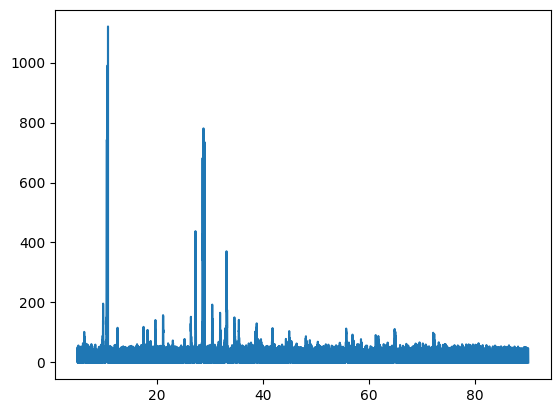

In [8]:
# Plotting an Example

plt.plot(x_values, data_tensor[1])
print("-------------")
print(labels[1])

In [9]:
# Get the number of samples
num_samples = data_tensor.shape[0]

# Create a random permutation of indices
indices = torch.randperm(num_samples)

# Shuffle the data_tensor
shuffled_data = data_tensor[indices]

# Shuffle the labels list using the same indices
shuffled_labels = [labels[i] for i in indices.tolist()]

# Calculate split index
split_idx = int(num_samples * 0.9)  # 90% for training

# Split the data
train_data = shuffled_data[:split_idx]
test_data = shuffled_data[split_idx:]

# Split the labels
train_labels = shuffled_labels[:split_idx]
test_labels = shuffled_labels[split_idx:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set size: 1134
Testing set size: 126


#--------------------------------------------
# Creating the NN

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

import torch
import torch.nn.functional as F

def prepare_labels_for_cross_entropy(labels, all_labels):
    # Create a dictionary mapping each unique label to a unique integer
    label_to_index = {label: idx for idx, label in enumerate(set(all_labels))}

    # Convert labels to their corresponding integers
    label_indices = [label_to_index[label] for label in labels]

    # Convert to tensor
    label_indices_tensor = torch.tensor(label_indices, dtype=torch.long)

    # Create one-hot encoded tensor
    num_classes = len(label_to_index)
    one_hot_labels = F.one_hot(label_indices_tensor, num_classes=num_classes)

    return one_hot_labels, label_indices_tensor, label_to_index

# Usage
#Alredy run...
#data_tensor, labels = process_all_files_in_directory(n=5)
one_hot_labels, label_indices, label_to_index = prepare_labels_for_cross_entropy(train_labels, train_labels)

print(f"One-hot labels shape: {one_hot_labels.shape}")
print(f"Label indices shape: {label_indices.shape}")



One-hot labels shape: torch.Size([1134, 28])
Label indices shape: torch.Size([1134])


In [12]:
print(one_hot_labels[0])
print(label_indices[0])
print(label_to_index)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor(8)
{'Tremolite': 0, 'Marialite': 1, 'Muscovite': 2, 'Almandine': 3, 'Spessartine': 4, 'AxiniteFe': 5, 'Topaz': 6, 'Vivianite': 7, 'Sphalerite': 8, 'Calcite': 9, 'Dravite': 10, 'Forsterite': 11, 'Dolomite': 12, 'Elbaite': 13, 'Actinolite': 14, 'Sodalite': 15, 'Beryl': 16, 'Epidote': 17, 'Grossular': 18, 'Cerussite': 19, 'Albite': 20, 'Diopside': 21, 'Anorthite': 22, 'Fluorapatite': 23, 'Spinel': 24, 'Andradite': 25, 'Pyrope': 26, 'Enstatite': 27}


In [13]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
W1 = torch.randn((8501, 800), generator=g)
b1 = torch.randn(800, generator=g)
W2 = torch.randn((800, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [W1, b1, W2, b2]
print(f"The NN has: {(sum(p.nelement() for p in parameters))} parameters" )

The NN has: 6824028 parameters


In [14]:
for p in parameters:
  p.requires_grad = True

In [15]:
while True:
    # forward pass
    h = torch.tanh(train_data @ W1 + b1)
    logits = h @ W2 + b2

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=1)

    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(logits, label_indices)

    print(f"The loss is: {loss}")
    if loss < 10e-3:
        print(f"Reached Stop Point!!")
        break

    loss.backward()

    for p in parameters:
        p.data += -0.1 * p.grad

The loss is: 55.40810775756836
The loss is: 52.08916091918945
The loss is: 48.01692199707031
The loss is: 42.72293472290039
The loss is: 37.64441680908203
The loss is: 32.70146179199219
The loss is: 28.247941970825195
The loss is: 23.36916732788086
The loss is: 19.379749298095703
The loss is: 16.430286407470703
The loss is: 13.21359920501709
The loss is: 11.11645221710205
The loss is: 9.327094078063965
The loss is: 7.361654281616211
The loss is: 5.849109649658203
The loss is: 4.808567523956299
The loss is: 4.157732963562012
The loss is: 3.339066982269287
The loss is: 2.9486167430877686
The loss is: 2.5274906158447266
The loss is: 2.3893253803253174
The loss is: 2.2325150966644287
The loss is: 2.0273916721343994
The loss is: 1.7706804275512695
The loss is: 1.545732855796814
The loss is: 1.350030541419983
The loss is: 1.2744414806365967
The loss is: 1.3139187097549438
The loss is: 1.2747492790222168
The loss is: 1.2578085660934448
The loss is: 1.220384120941162
The loss is: 1.11804056167

Predicted label: Albite
Expected label: Albite
Probability: 1.0000


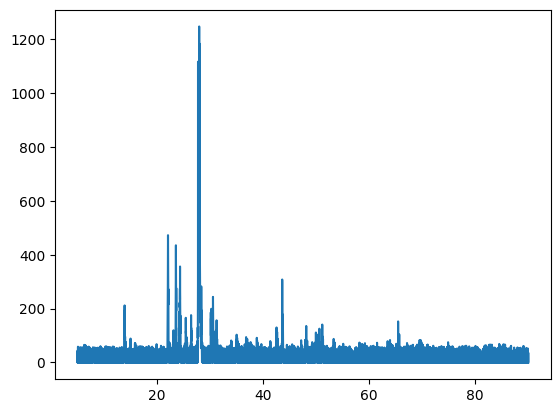

In [17]:

index_to_label = {v: k for k, v in label_to_index.items()}  # Reverse the dictionary


def test_example(i):
  # For a single example (the first one in data_tensor)
  h = torch.tanh(test_data[i] @ W1 + b1)
  logits = h @ W2 + b2

  # Apply softmax to get probabilities
  probabilities = F.softmax(logits, dim=0)  # Note: dim=0 for a single example
  #print("Probabilities:", probabilities)
  max_prob_index = torch.argmax(probabilities).item()
  #print(max_prob_index)

  predicted_label = index_to_label[max_prob_index]

  print(f"Predicted label: {predicted_label}")
  print(f"Expected label: {test_labels[i]}")
  print(f"Probability: {probabilities[max_prob_index].item():.4f}")

test_example(50)
plt.plot(x_values, test_data[50])